# Search for a good threshold for HOME and WORK inferrence

In [1]:
import os
import pandas as pd

os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
output_notebook()

from src.dao import places_dao, csv_dao
from src.utils import geo
from src.entity.stop_region import sr_row_to_stop_region

from sklearn.model_selection import KFold

working dir /home/tales/dev/master/mdc_analysis


Loading BokehJS ...

## Loading and preparing data

In [2]:
def partition(data, train_ratio):
    size = int(len(data) * train_ratio)
    train_ids = data.sample(size).index
    test_ids = data[~data.index.isin(train_ids)].index
    return {"train_ids": train_ids, "test_ids": test_ids}

def split_places(places_data, ratios_df, places_col):
    split_data = {}
    for user_id, row in ratios_df.iterrows():
        data = partition(places_data[user_id][places_col], ratios_df.loc[user_id]["ratio"].item())
        
        train = data.loc[data["train_ids"]]
        test = data.loc[data["test_ids"]]
        
        split_data[user_id] = {"train": train, "test": test}
    
    return split_data

In [3]:
user_id = 6070
user_places = places_dao.load_stop_regions_home(user_id)

ratio = len(user_places["home"]) / len(user_places["not_home"])

In [4]:
user_ids = csv_dao.list_stop_region_usernames()

places_data = {}
ratios = []

place_col = "home"
not_place_col = "not_home"

for user_id in user_ids:
    print("Loading user {} data".format(user_id))
    user_places = places_dao.load_stop_regions_home(user_id)
    
    user_places[place_col] = user_places[place_col].set_index("sr_id", drop=False)
    user_places[not_place_col] = user_places[not_place_col].set_index("sr_id", drop=False)
    
    ratios.append( {"ratio": (len(user_places[place_col])) / (len(user_places[place_col]) + len(user_places[not_place_col])),
                    "user_id": user_id,
                    "size_place": len(user_places[place_col]),
                    "size_not_place": len(user_places[not_place_col])} )
    places_data[user_id] = user_places

Loading user 6189 data
Loading user 5936 data
Loading user 6087 data
Loading user 5973 data
Loading user 6085 data
Loading user 6074 data
Loading user 6012 data
Loading user 5982 data
Loading user 5948 data
Loading user 5974 data
Loading user 6090 data
Loading user 6199 data
Loading user 6068 data
Loading user 6024 data
Loading user 5976 data
Loading user 6094 data
Loading user 5941 data
Loading user 5995 data
Loading user 5962 data
Loading user 6093 data
Loading user 6033 data
Loading user 6079 data
Loading user 6038 data
Loading user 6175 data
Loading user 6042 data
Loading user 5924 data
Loading user 6083 data
Loading user 6178 data
Loading user 5958 data
Loading user 6086 data
Loading user 6100 data
Loading user 5945 data
Loading user 5925 data
Loading user 5935 data
Loading user 6172 data
Loading user 5955 data
Loading user 6073 data
Loading user 5980 data
Loading user 6010 data
Loading user 5993 data
Loading user 6037 data
Loading user 5979 data
Loading user 5966 data
Loading use

In [5]:
ratios = pd.DataFrame(ratios)
ratios = ratios.set_index("user_id")
ratios.head(6)

,ratio,size_not_place,size_place
user_id,,,
6189,0.062718,538,36
5936,0.015769,749,12
6087,0.036066,588,22
5973,0.278829,4384,1695
6085,0.016452,1375,23
6074,0.000000,45,0


count    163.000000
mean       0.057106
std        0.085011
min        0.000000
25%        0.000000
50%        0.017291
75%        0.075407
max        0.433837
Name: ratio, dtype: float64


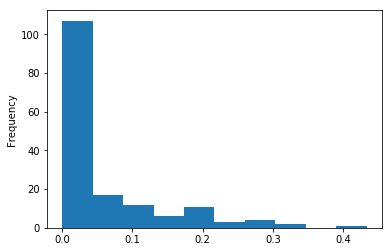

In [6]:
print(ratios["ratio"].describe())
ratios["ratio"].plot.hist()

## Testing different radius value

In [30]:
def try_radius_place_inferrence(train_sr_df, test_sr_df, radius):
    train_stop_regions = train_sr_df.apply(sr_row_to_stop_region, axis=1)
    test_stop_regions = test_sr_df.apply(sr_row_to_stop_region, axis=1)
    
    inferrence = []
    rejected = []
    
    for train_sr in train_stop_regions:
        for test_sr in test_stop_regions:
            if type(train_sr) is str:
                print("train_sr", train_sr)
                print(train_sr_df)
                print()
                continue
            if train_sr.distance_to_another_sr(test_sr) <= radius:
                inferrence.append(test_sr.sr_id)
            else:
                rejected.append(test_sr.sr_id)
        
    return list(set(inferrence))

In [31]:
# search_tolerance = 0.0007
# print("A tolerance of {} can be user to search over a radius {}m".format(search_tolerance, round(geo.distance_epsg_4326(46, 7, 46 + search_tolerance, 7 + search_tolerance), 2)))

## Home Inferrence

In [40]:
radius_list = list(range(30))
user_ratio = 0.5

result = []

for iteration in range(5):
    for radius in radius_list:
        print("radius: {}, iteration: {}".format(radius, iteration))

        for user_id in places_data.keys():
            row = {"user_id": user_id}
            if len(places_data[user_id]["home"]) <= 1:
                continue

            partitions = partition(places_data[user_id]["home"], user_ratio)
            train = places_data[user_id]["home"].loc[partitions["train_ids"]]
            test = places_data[user_id]["home"].loc[partitions["test_ids"]]

            home_inferrence = try_radius_place_inferrence(train, test, radius)

            tp_counter = 0
            for sr_id in home_inferrence:
                if "HOME" in test.loc[sr_id]["tag"]:
                    tp_counter += 1

            row["test_size"] = len(test)
            row["TP"] = tp_counter
            row["FN"] = row["test_size"] - row["TP"]
            row["radius"] = radius
            row["iteration"] = iteration

            result.append(row)
        
result = pd.DataFrame(result)[["user_id", "radius", "iteration","FN", "TP", "test_size"]]
result["FN_p"] = result["FN"] / result["test_size"]
result["TP_p"] = result["TP"] / result["test_size"]

radius: 0, iteration: 0


/home/tales/dev/master/mdc_analysis/src/entity/stop_region.py:67: FutureWarning: 'place_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.close_pois = google_places.load_all_google_places_data(valid_pois=True).merge(pois, on="place_id", how="inner").sort_values(by="distance")


radius: 1, iteration: 0
radius: 2, iteration: 0
radius: 3, iteration: 0
radius: 4, iteration: 0
radius: 5, iteration: 0
radius: 6, iteration: 0
radius: 7, iteration: 0
radius: 8, iteration: 0
radius: 9, iteration: 0
radius: 10, iteration: 0
radius: 11, iteration: 0
radius: 12, iteration: 0
radius: 13, iteration: 0
radius: 14, iteration: 0
radius: 15, iteration: 0
radius: 16, iteration: 0
radius: 17, iteration: 0
radius: 18, iteration: 0
radius: 19, iteration: 0
radius: 20, iteration: 0
radius: 21, iteration: 0
radius: 22, iteration: 0
radius: 23, iteration: 0
radius: 24, iteration: 0
radius: 25, iteration: 0
radius: 26, iteration: 0
radius: 27, iteration: 0
radius: 28, iteration: 0
radius: 29, iteration: 0
radius: 0, iteration: 1
radius: 1, iteration: 1
radius: 2, iteration: 1
radius: 3, iteration: 1
radius: 4, iteration: 1
radius: 5, iteration: 1
radius: 6, iteration: 1
radius: 7, iteration: 1
radius: 8, iteration: 1
radius: 9, iteration: 1
radius: 10, iteration: 1
radius: 11, iterati

In [50]:
result.to_csv("notebooks/outputs/close_home_and_work_inferrence_result.csv", index=False)

In [53]:
result.sample(10)

,user_id,radius,iteration,FN,TP,test_size,FN_p,TP_p
593,5962,6,0,14,27,41,0.341463,0.658537
849,6104,8,0,7,2,9,0.777778,0.222222
7018,5937,12,2,1,0,1,1.000000,0.000000
5710,6032,28,1,2,10,12,0.166667,0.833333
4039,5959,11,1,5,354,359,0.013928,0.986072
2022,6030,20,0,5,2,7,0.714286,0.285714
331,6001,3,0,18,11,29,0.620690,0.379310
4332,6029,14,1,2,1,3,0.666667,0.333333
13387,5936,18,4,1,5,6,0.166667,0.833333
8567,6041,28,2,0,12,12,0.000000,1.000000


In [87]:
def plot_result(result_df):
    radius = result_df["radius"].drop_duplicates().tolist()
    tp_list_75 = result_df.groupby("radius")["TP_p"].describe()["75%"].tolist()
    tp_list_50 = result_df.groupby("radius")["TP_p"].describe()["50%"].tolist()
    tp_list_25 = result_df.groupby("radius")["TP_p"].describe()["25%"].tolist()

    p = figure(plot_width=500, plot_height=300, title="True Positive percentage VS Radius")

    # true positives quartil 3
    p.line(radius, tp_list_75, color="darkblue", alpha=0.8, line_width=2)
    p.circle(radius, tp_list_75, color="darkblue", fill_alpha=1, size=4, legend="T positives quartile 3")

    # true positives quartil 2
    p.line(radius, tp_list_50, color="blue", alpha=0.8, line_width=2)
    p.circle(radius, tp_list_50, color="blue", fill_alpha=1, size=4, legend="T positives quartile 2")

    # true positives quartil 1
    p.line(radius, tp_list_25, color="lightblue", alpha=0.8, line_width=2)
    p.circle(radius, tp_list_25, color="lightblue", fill_alpha=1, size=4, legend="T positives quartile 1")

    
    p.legend.location = "bottom_right"

    return p

In [88]:
p = plot_result(result)
show(p)

In [91]:
result.groupby("radius")["TP_p"].describe()

,count,mean,std,min,25%,50%,75%,max
radius,,,,,,,,
0,485.0,0.354429,0.440917,0.0,0.000000,0.046875,0.994104,1.0
1,485.0,0.381991,0.436438,0.0,0.000000,0.105263,0.992925,1.0
2,485.0,0.451560,0.423170,0.0,0.000000,0.312500,0.998821,1.0
3,485.0,0.504929,0.408855,0.0,0.076923,0.439024,1.000000,1.0
4,485.0,0.546586,0.400210,0.0,0.153846,0.607143,1.000000,1.0
5,485.0,0.585264,0.389759,0.0,0.200000,0.666667,1.000000,1.0
6,485.0,0.618819,0.373540,0.0,0.285714,0.714286,1.000000,1.0
7,485.0,0.653914,0.361203,0.0,0.333333,0.781250,1.000000,1.0
8,485.0,0.664854,0.362013,0.0,0.333333,0.815789,1.000000,1.0


## Work Inference

In [56]:
user_ids = csv_dao.list_stop_region_usernames()

places_data_work = {}
ratios_work = []

place_col = "work"
not_place_col = "not_work"

for user_id in user_ids:
    print("Loading user {} data".format(user_id))
    user_places = places_dao.load_stop_regions_work(user_id)
    
    user_places[place_col] = user_places[place_col].set_index("sr_id", drop=False)
    user_places[not_place_col] = user_places[not_place_col].set_index("sr_id", drop=False)
    
    ratios_work.append( {"ratio": (len(user_places[place_col])) / (len(user_places[place_col]) + len(user_places[not_place_col])),
                    "user_id": user_id,
                    "size_place": len(user_places[place_col]),
                    "size_not_place": len(user_places[not_place_col])} )
    places_data_work[user_id] = user_places

Loading user 6189 data
Loading user 5936 data
Loading user 6087 data
Loading user 5973 data
Loading user 6085 data
Loading user 6074 data
Loading user 6012 data
Loading user 5982 data
Loading user 5948 data
Loading user 5974 data
Loading user 6090 data
Loading user 6199 data
Loading user 6068 data
Loading user 6024 data
Loading user 5976 data
Loading user 6094 data
Loading user 5941 data
Loading user 5995 data
Loading user 5962 data
Loading user 6093 data
Loading user 6033 data
Loading user 6079 data
Loading user 6038 data
Loading user 6175 data
Loading user 6042 data
Loading user 5924 data
Loading user 6083 data
Loading user 6178 data
Loading user 5958 data
Loading user 6086 data
Loading user 6100 data
Loading user 5945 data
Loading user 5925 data
Loading user 5935 data
Loading user 6172 data
Loading user 5955 data
Loading user 6073 data
Loading user 5980 data
Loading user 6010 data
Loading user 5993 data
Loading user 6037 data
Loading user 5979 data
Loading user 5966 data
Loading use

In [63]:
ratios_work = pd.DataFrame(ratios_work)
ratios_work = ratios_work.set_index("user_id")
ratios_work.head(6)

,ratio,size_not_place,size_place
user_id,,,
6189,0.076655,530,44
5936,0.081472,699,62
6087,0.059016,574,36
5973,0.011022,6012,67
6085,0.048641,1330,68
6074,0.022222,44,1


In [70]:
radius_list = list(range(30))
user_ratio = 0.5

result_work = []

for iteration in range(5):
    for radius in radius_list:
        print("radius: {}, iteration: {}".format(radius, iteration))

        for user_id in places_data_work.keys():
            row = {"user_id": user_id}
            if len(places_data_work[user_id]["work"]) <= 1:
                continue

            partitions = partition(places_data_work[user_id]["work"], user_ratio)
            train = places_data_work[user_id]["work"].loc[partitions["train_ids"]]
            test = places_data_work[user_id]["work"].loc[partitions["test_ids"]]

            work_inferrence = try_radius_place_inferrence(train, test, radius)

            tp_counter = 0
            for sr_id in work_inferrence:
                if "WORK" in test.loc[sr_id]["tag"]:
                    tp_counter += 1

            row["test_size"] = len(test)
            row["TP"] = tp_counter
            row["FN"] = row["test_size"] - row["TP"]
            row["radius"] = radius
            row["iteration"] = iteration

            result_work.append(row)
        
result_work = pd.DataFrame(result_work)[["user_id", "radius", "iteration","FN", "TP", "test_size"]]
result_work["FN_p"] = result_work["FN"] / result_work["test_size"]
result_work["TP_p"] = result_work["TP"] / result_work["test_size"]

radius: 0, iteration: 0


/home/tales/dev/master/mdc_analysis/src/entity/stop_region.py:67: FutureWarning: 'place_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.close_pois = google_places.load_all_google_places_data(valid_pois=True).merge(pois, on="place_id", how="inner").sort_values(by="distance")


radius: 1, iteration: 0
radius: 2, iteration: 0
radius: 3, iteration: 0
radius: 4, iteration: 0
radius: 5, iteration: 0
radius: 6, iteration: 0
radius: 7, iteration: 0
radius: 8, iteration: 0
radius: 9, iteration: 0
radius: 10, iteration: 0
radius: 11, iteration: 0
radius: 12, iteration: 0
radius: 13, iteration: 0
radius: 14, iteration: 0
radius: 15, iteration: 0
radius: 16, iteration: 0
radius: 17, iteration: 0
radius: 18, iteration: 0
radius: 19, iteration: 0
radius: 20, iteration: 0
radius: 21, iteration: 0
radius: 22, iteration: 0
radius: 23, iteration: 0
radius: 24, iteration: 0
radius: 25, iteration: 0
radius: 26, iteration: 0
radius: 27, iteration: 0
radius: 28, iteration: 0
radius: 29, iteration: 0
radius: 0, iteration: 1
radius: 1, iteration: 1
radius: 2, iteration: 1
radius: 3, iteration: 1
radius: 4, iteration: 1
radius: 5, iteration: 1
radius: 6, iteration: 1
radius: 7, iteration: 1
radius: 8, iteration: 1
radius: 9, iteration: 1
radius: 10, iteration: 1
radius: 11, iterati

In [74]:
result_work.groupby("radius").mean()

,iteration,FN,TP,test_size,FN_p,TP_p
radius,,,,,,
0,2.0,13.607059,27.745882,41.352941,0.308874,0.691126
1,2.0,11.209412,30.143529,41.352941,0.300148,0.699852
2,2.0,6.769412,34.583529,41.352941,0.262773,0.737227
3,2.0,5.023529,36.329412,41.352941,0.238102,0.761898
4,2.0,3.922353,37.430588,41.352941,0.213826,0.786174
5,2.0,3.505882,37.847059,41.352941,0.214805,0.785195
6,2.0,2.743529,38.609412,41.352941,0.191426,0.808574
7,2.0,2.294118,39.058824,41.352941,0.168848,0.831152
8,2.0,2.065882,39.287059,41.352941,0.162719,0.837281


In [89]:
p_work = plot_result(result_work)
show(p_work)

In [92]:
result_work.to_csv("notebooks/outputs/close_home_and_work_inferrence_result_work.csv", index=False)